# Inicializacion e imports

In [1]:
HOST = "http://127.0.0.1:3000/"

PROJECT_NAME = "NPF Detector"
EXPERIMENT_NAME = "512 Gaussian model"
EXPERIMENT_DESCRIPTION = "Inicializo con HInit. Restimo (x5) con HERest ('-t', 250.0, 150.0, 1000.0). \
                          Guardo los archivos en cm-3.\
                          Subo el numero de gaussianas hasta 512 [1,2,4,8,16,32,64,128,256,512]"

%reload_ext autoreload

%autoreload 2

import src.visualization.visualize as viz
import src.HTK.htktools as htkt
import src.HTK.scripts as scripts

scripts.clean_interim()
scripts.clean_models()

# Inicializo Verta

In [44]:
from verta import Client

client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run(desc=EXPERIMENT_DESCRIPTION)

connection successfully established
set existing Project: NPF Detector from personal workspace
set existing Experiment: 512 Gaussian model
created new ExperimentRun: Run 1158615962138074042053


# Logueo los archivos que voy a usar en el HTK

In [43]:
run.log_artifact("HTK_misc","../src/HTK/misc", overwrite=True)

scripts.display_artifact(which=['config.hcopy'])

upload complete (HTK_misc)
****   src/HTK/misc/config.hcopy   ****

# Coding parameters
SOURCEKIND = USER
TARGETKIND = USER_D_A_Z



# Preparo los datos

Convierto los datos crudos a formato HTK, separando 90% para entrenar y 10% para testear. Tambien creo los archivos necesarios para usar en HTK (train.scp, test.scp)

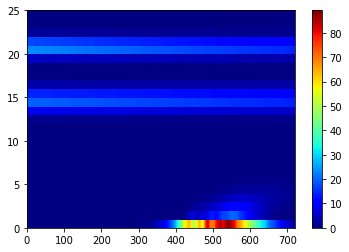

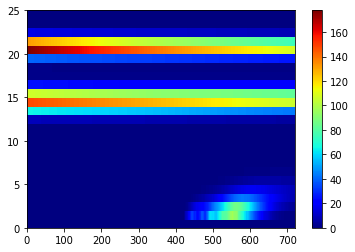

In [45]:
viz.raw_file('0.0-20150124.h5')
viz.raw_file_as_dndlogdp('0.0-20150124.h5')

In [6]:
scripts.setup_data(convert_to_dndlogdp=False)
run.log_hyperparameters({'convert_to_dndlogdp': False})

INFO:root:Converting raw files to HTK format ...
INFO:root:Files converted OK!


In [1]:
thresholds = {'nuc_threshold': 0.2,       # 1/cm3/10min
             'con_threshold': 220,       # 1/m3^3/10min
             'coa_threshold': 2,         # 1/cm3/10min
             'dep_threshold': 2500}      # 1/m3^3/10min

viz.evaluate_hyperparameter_for_label_debug('0.0-20150123.h5', thresholds)



NameError: name 'viz' is not defined

In [8]:
run.log_hyperparameters(thresholds)

In [9]:
scripts.make_labels(thresholds)

INFO:root:Creating labels ...
INFO:root:Labels created OK!
INFO:root:Generating script (.scp) files...


Agrego las deltas y las aceleraciones tanto para test como para train:

In [10]:
# Test
n = htkt.HCopy(['-C', '../src/HTK/misc/config.hcopy',
        '-S', '../data/interim/test_hcopy.scp',
        '-T', 1])


run.log_observation('number_of_test_files', n)

# Train
n = htkt.HCopy(['-C', '../src/HTK/misc/config.hcopy',
        '-S', '../data/interim/train_hcopy.scp',
        '-T', 1])

run.log_observation('number_of_train_files', n)


In [11]:
scripts.gen_scp_files()
scripts.gen_MLF()

INFO:root:Generating script (.scp) files...


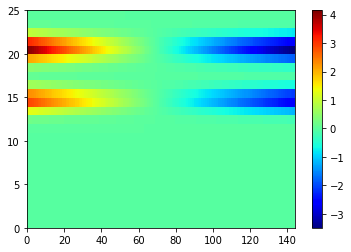

In [12]:
viz.testDA_file()

### Inicializo el modelo de Markov

In [14]:
# Limpio todas todos los modelos y creo el modelo prototipo
scripts.clean_models()

In [15]:
most_trained_model = 0

htkt.HCompV(['-C', '../src/HTK/misc/config',
             '-S', '../data/interim/train.scp',
             '-M', '../models/hmm/' + str(most_trained_model),
             '-T', 1,
             '-f', 0.1,
             '-m',
             '../src/HTK/misc/proto'])

for label in ['nuc', 'coa', 'con', 'equ']:
    htkt.HInit(['-C', '../src/HTK/misc/config',
                '-S', '../data/interim/train.scp',
                '-I', '../data/interim/size_distribution_labels.mlf', 
                '-M', '../models/hmm/' + str(most_trained_model)+'/',
                '-T', 1,
                '-l', label,
                '-o', label,
                #'-v', 0.1,
                '../src/HTK/misc/proto'])
    


Calculating Fixed Variance
  HMM Prototype: ../src/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: ../models/hmm/0
222192 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory ../models/hmm/0
Var floor macros output to file ../models/hmm/0/vFloors

Initialising  HMM ../src/HTK/misc/proto . . . 
 States   :   2  3  4 (width)
 Mixes  s1:   1  1  1 ( 75  )
 Num Using:   0  0  0
 Parm Kind:  USER_D_A
 Number of owners = 1
 SegLab   :  nuc
 maxIter  :  20
 epsilon  :  0.000100
 minSeg   :  3
 Updating :  Means Variances MixWeights/DProbs TransProbs

 - system is PLAIN
1007 Observation Sequences Loaded
Starting Estimation Process
Iteration 1: Average LogP =  -210.06856
Iteration 2: Average LogP =   234.68356  Change =   444.75214
Iteration 3: Average LogP =   306.17355  Change =    71.48999
Iteration 4: Average LogP =   312.42316  Change =     6.24960
Iteration 5: Average LogP =   316.77728  Change =     4.35413

In [16]:
scripts.gen_hmmdefs()
scripts.gen_macros()

Edito el el archivo hmmdefs y le agrego los modelos creados con HInit

### Estimo los parametros

In [46]:
most_trained_model=0
n = 5

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 150.0,# 50.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_1_gaussian', '../models/hmm/' + str(most_trained_model), overwrite=True)

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

upload complete (model_1_gaussian)


### Evaluo

In [18]:
htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(1),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/5/macros -H ../models/hmm/5/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_1 ../src/HTK/misc/dict ../src/HTK/misc/monophones 



In [19]:
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '-p',
                   '../src/HTK/misc/monophones',
                   '../data/interim/results_' + str(1)])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_1_gaussian', r['WORD_Corr'])

====================== HTK Results Analysis =======================
  Date: Wed Jul 29 16:43:26 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_1
------------------------ Overall Results --------------------------
SENT: %Correct=39.11 [H=79, S=123, N=202]
WORD: %Corr=40.30, Acc=23.29 [H=218, D=245, S=78, I=92, N=541]
------------------------ Confusion Matrix -------------------------
       e   n   c   d 
       q   u   o   e 
       u   c   a   p  Del [ %c / %e]
 equ  190  0  61   2  116 [75.1/11.6]
 nuc   0  26   3  12  126 [63.4/2.8]
 coa   0   0   1   0    0
 con   0   0   0   0    1
 dep   0   0   0   1    2
Ins    1   0  64  27



### Agrego la transicion entre los estados 2 y 4 para el estado estaiconario

In [20]:
htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/add_equ_24_trans.hed',
           '../src/HTK/misc/monophones'])

most_trained_model

5

### Edito el modelo, ahora uso 2 gaussianas

In [21]:
#most_trained_model = 3
print("Modelo inicial:", most_trained_model)
number_of_gaussians = 2

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, #150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

print("Modelo Final:", most_trained_model)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_2gaussians', r['WORD_Corr'])

Modelo inicial: 5

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

upload complete (model_2_gaussian)
Modelo Final: 11
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/11/macros -H ../models/hmm/11/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/tes

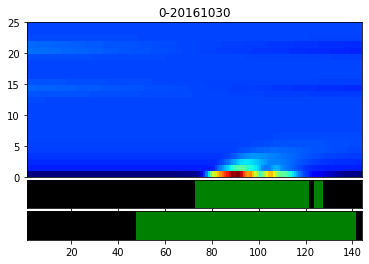

In [39]:
viz.evaluate_results(n_gaussians=2)

### Edito el modelo, ahora uso 4 gaussianas

In [40]:
#most_trained_model = 6
number_of_gaussians = 4

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
print("Modelo final:", most_trained_model)    
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_4_gaussians', r['WORD_Corr'])

Modelo inicial: 11

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-Off
 WARNING [-2331]  UpdateModels: coa[1] copied: only 0 egs
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Modelo final: 17
upload complete (model_4_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/17/macros -H ../models/hmm/17/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/te

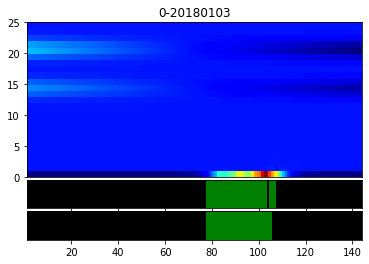

In [42]:
viz.evaluate_results(n_gaussians=4)

### Edito el modelo, ahora uso 8 gaussianas

In [382]:
#most_trained_model = 9
number_of_gaussians = 8

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            #'-p', 0,
            #'-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_8_gaussians', r['WORD_Corr'])

Modelo inicial: 17

Pruning-Off

Pruning-Off

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 22
upload complete (model_8_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/22/macros -H ../models/hmm/22/hmmdefs -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_8 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 23 12:58:26 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_8
------------------------ Overall Results --------------------------
SENT: %Correct=62.11 [H=100, S=61, N=161]
WORD: %Corr=64.69, Acc=50.77 [H=251, D=120, S=17, I=54, N=388]



### Edito el modelo, ahora uso 16 gaussianas

In [457]:
#most_trained_model = 22
number_of_gaussians = 16

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '-p',
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_16_aussians', r['WORD_Corr'])

Modelo inicial: 22

Pruning-Off

Pruning-Off

Pruning-Off

Pruning-Off

Pruning-Off

Modelo final: 28
upload complete (model_16_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/28/macros -H ../models/hmm/28/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_16 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 23 16:16:49 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_16
------------------------ Overall Results --------------------------
SENT: %Correct=59.63 [H=96, S=65, N=161]
WORD: %Corr=65.98, Acc=48.20 [H=256, D=112, S=20, I=69, N=388]
------------------------ Confusion Matrix -------------------------
       e   n   c   c   d 
       q   u   o   o   e 
       u   c   a   n   p  Del [ %c / %e]
 equ  202  0   2  11   0   44 [94.0/3.4]
 nuc

ValueError: metric with key correct_16_aussians already exists; consider using observations instead

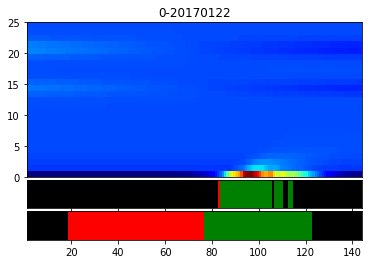

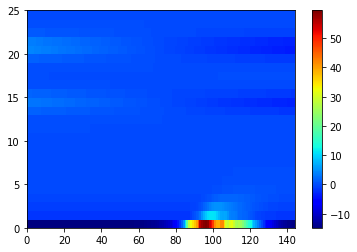

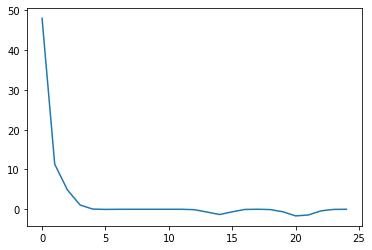

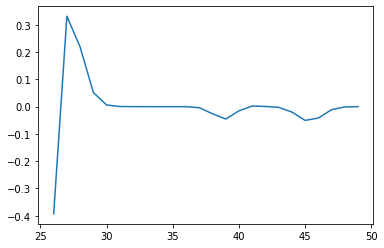

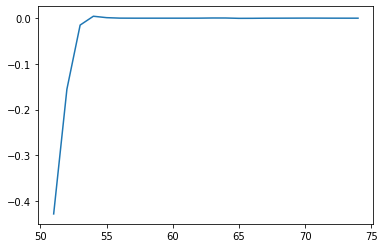

In [448]:
viz.evaluate_results('0-20170122', n_gaussians=16)
viz.testDA_file('0-20170122', sample=100)

### Edito el modelo, ahora uso 32 gaussianas

In [401]:
#most_trained_model = 15
number_of_gaussians = 32

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_32_gaussians', r['WORD_Corr'])

Modelo inicial: 28
 WARNING [-2637]  HeaviestMix: mix 8 in con has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 15 in con has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 34
upload complete (model_32_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/34/macros -H ../models/hmm/34/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_32 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Thu Jul 23 13:00:51 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec :

### Edito el modelo, ahora uso 64 gaussianas

In [402]:
#most_trained_model = 18
number_of_gaussians = 64

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_64_gaussians', r['WORD_Corr'])

Modelo inicial: 34
 WARNING [-2637]  HeaviestMix: mix 3 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 4 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 6 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 7 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 11 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 12 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 13 in coa has 

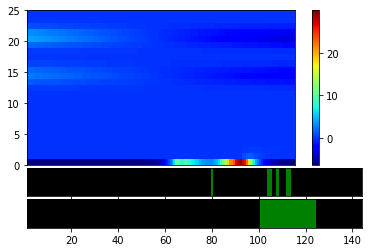

In [409]:
viz.evaluate_results(n_gaussians=64)

### Edito el modelo, ahora uso 128 gaussianas

In [410]:
#most_trained_model = 21
number_of_gaussians = 128

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_128_gaussians', r['WORD_Corr'])

Modelo inicial: 40
 WARNING [-2637]  HeaviestMix: mix 1 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 5 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 7 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 9 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 10 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 11 in coa has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 13 in coa has 

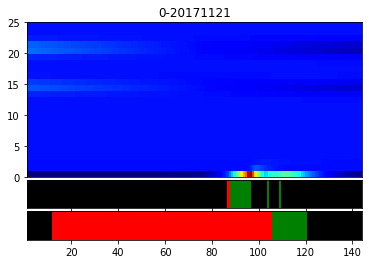

In [465]:
viz.evaluate_results(n_gaussians=128)

### Edito el modelo, ahora uso 256 gaussianas

In [162]:
#most_trained_model = 24
number_of_gaussians = 256

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 #'-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_256_gaussians', r['WORD_Corr'])

Modelo inicial: 24
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd -H ../models/hmm/24/macros -H ../models/hmm/24/hmmdefs -M ../models/hmm/25 ../src/HTK/misc/pow256.hed ../src/HTK/misc/monophones
  ERROR [+2697]  HeaviestMix:  heaviest mix is defunct!
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 27
upload complete (model_256_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/27/macros -H ../models/hmm/27/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_256 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Mon Jul 20 16:36:28 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/res

### Edito el modelo, ahora uso 512 gaussianas

In [172]:
most_trained_model = 27
number_of_gaussians = 512

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            '-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_512_gaussians', r['WORD_Corr'])

Modelo inicial: 27
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd -H ../models/hmm/27/macros -H ../models/hmm/27/hmmdefs -M ../models/hmm/28 ../src/HTK/misc/pow512.hed ../src/HTK/misc/monophones
  ERROR [+2697]  HeaviestMix:  heaviest mix is defunct!
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 30
upload complete (model_512_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/30/macros -H ../models/hmm/30/hmmdefs -p 0 -s 5 -A -T 1 -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_512 ../src/HTK/misc/dict ../src/HTK/misc/monophones 
Read 5 physical / 5 logical HMMs
Read lattice with 8 nodes / 16 arcs
Created network with 15 nodes / 23 links
File: ../data/interim/test_D_A/0-20170720
equ dep equ  ==  [144 fra

ValueError: metric with key correct_512_gaussians already exists; consider using observations instead

In [462]:
viz.evaluate_results(n_gaussians=512)

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/results_512'

### Evaluo algunos casos reales

In [426]:
htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 1,
            '-s', 5,
            '-A',
            '-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test_real_data.scp',
            '-i', '../data/interim/results_real_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_real_' + str(number_of_gaussians)])

# for k,v in r.items():
#     run.log_observation(k,v)
    
# run.log_metric('correct_512_gaussians', r['WORD_Corr'])

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/45/macros -H ../models/hmm/45/hmmdefs -p 1 -s 0.5 -A -T 1 -w ../src/HTK/misc/wdnet -S ../data/interim/test_real_data.scp -i ../data/interim/results_real_128 ../src/HTK/misc/dict ../src/HTK/misc/monophones 
Read 5 physical / 5 logical HMMs
Read lattice with 8 nodes / 16 arcs
Created network with 15 nodes / 23 links
File: ../data/external/DM20171110
No tokens survived to final node of network
File: ../data/external/DM20171113
No tokens survived to final node of network
File: ../data/external/DM20171115
No tokens survived to final node of network

No transcriptions found



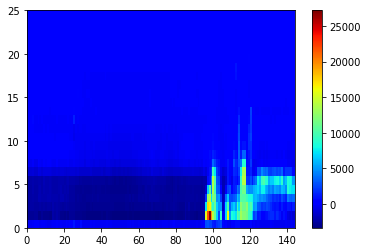

In [413]:
viz.real_file('DM20171115')